# HW8.1 Text classification (sentiment analysis) with deep learning models

Instructor: Shuo Zhang

Student: Madelyn Silveira

Date: 03/09/2025

- Builds various deep learning model architectures for text classification.
- Uses IMBD movie review data for the sentiment classification task.
- Uses GPU to parallelize training.

Tips:
- print out the data types and shapes after each step to verify you are doing what you expected to do.
- when you build the model, pass in the validation data in `model.fit()` as an argument `validation_data=(X_val, Y_val)`. The test data should be reserved until after you trained the model and then you can test it with X_test and report the test accuracy. **Always report accuracy on Test data for each experiment you do and make the comparison based on Test data.**

## 1. Load the IMDB dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Bidirectional

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# check that I have at least one GPU to run on
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


### Preprocess the data

**Dataset documentation:** https://keras.io/api/datasets/imdb/
- 25,000 movie reviews labeled by sentiment (positive/negative)
- Reviews have been preprocessed, where each review is encoded as a list of word indexes (integers)
- Words are indexed by overall frequency in the dataset. You can recover the word from the integer encoding with get_word_index().


**Important hyperparameters:**

1. `vocab_size` : when set to 5000, the model only keeps the top 5000 most frequent words in the vocablulary. Any words below frequency threshold are thrown out. This helpes reduce memory usage, improve training speed, and avoid overfitting on rare words.
2. `max_review_length` : when set to 500, the model ensures all review texts are of length 500. Reviews > 500 words will be truncated. Reviews < 500 words will be padded with 0s or special padding token. This is because all input sentences are required to be the same size for batched training. Most sentiments will come accross within 500 words, more than that is likely tangential.
3. `embedding_vector_length` : this is the embedding vector each word projects to. Start at 256. If training goes quick enough, increase to 512.



In [3]:
# keep the top 5000 most frequent words in the vocabulary
vocab_size = 5000

# ensure all input texts are the same size for batched training
max_review_length = 500

# specify the vector projection of each word
embedding_vector_length = 256

# load the dataset, keeping only top 5000 words
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Review lengths before and after padding

In [4]:
# get all lengths in dataset
lengths = [len(review) for review in X_train]

# print out the length of the first 20 reviews
print(f"First 20 review lengths: {lengths[:20]}")

First 20 review lengths: [218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177]


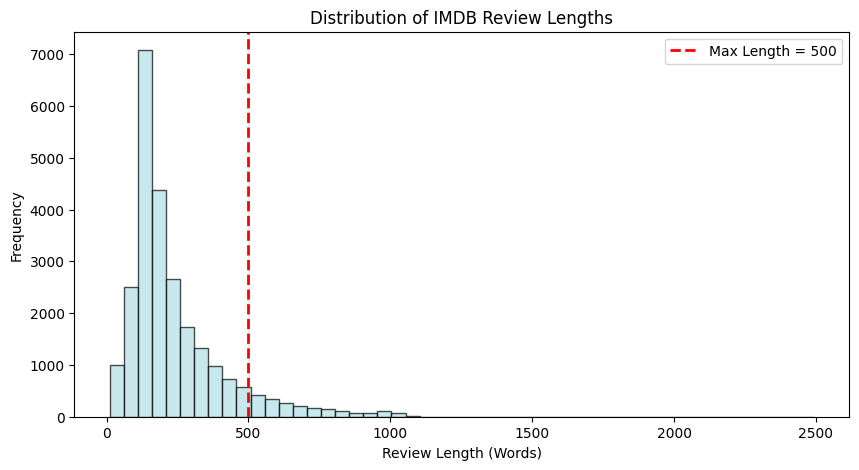

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# visualize the distribution of lengths
def plot_length_distribution(lengths):
    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=50, color="powderblue", edgecolor="black", alpha=0.7)
    plt.axvline(x=500, color='red', linestyle='dashed', linewidth=2, label="Max Length = 500")
    plt.xlabel("Review Length (Words)")
    plt.ylabel("Frequency")
    plt.title("Distribution of IMDB Review Lengths")
    plt.legend()
    plt.show()

plot_length_distribution(lengths)

Looks like 500 is a good max length. Let's actually set the lengths now:

First 20 review lengths: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


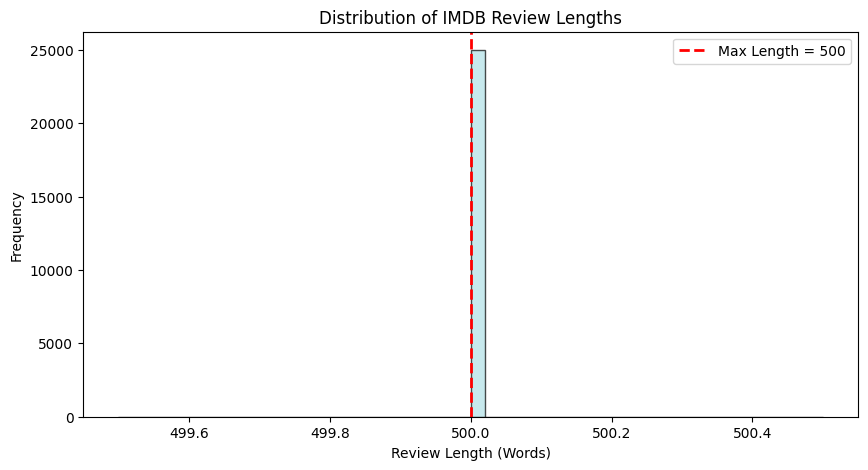

In [6]:
# truncate and pad input sequences
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

# review the lengths again
lengths = [len(review) for review in X_train]
print(f"First 20 review lengths: {lengths[:20]}")
plot_length_distribution(lengths)

Now they are all the same length for batched training. Let's inspect two examples:

In [7]:
# inspect the 24rd review:
print(f"24th:\n{X_train[23]}")

# inspect the 2nd review:
print(f"\n2nd:\n{X_train[1]}")

24th:
[  65    9   82  283    8  113   48   64   12   16 1391    6  117  128
   13  421   15    4   53 2428  537   11   14    2    2   71  579   39
    4  915  213    7  650   63    9  478   21   12  961  180    4  921
    2    7  134  537   88    4  668  105    2    2    5    2    2   11
  843   28   32    4 1137    7    6  320 1061 4548    2  286   14   22
  424    8   30   44    2  275    2  150    4  156  308    2  131  738
    8  850  116  137    2    2    9    2    5 3308   17  126    2 4029
  214    6  217  398   43   18   90   21  518    2    4 3262    7   27
  109  237   59  161   79    6    2  109    8 1975    2    2 1077   41
 1220 1826    5 1249  116  405    8 1108   56   18   12    2    2    9
  478  466  170    6    2  120    4  350   11    6  171  139    2    2
   47  164   76    8   81   21   59  127 3027  178   15  442    4  172
  250   37  770  178   19   41    2  239   11    2    2  497    8   97
   56   18   15  666 1323  446    2    2    5 2880    8    6 1058 2826


It looks like the 24th example might have been truncated by the 500 word max constraint, while the second example was padded in the beginning with zeroes to meet the 500 word requirement. I was initially surprised that tensorflow pads from the beginning by default, but I guess it makes sense because then it uniformly applies a start token at the start of each without having to calculate an end token.

### Split training data and label into train and validation sets, X_train and X_val.

Let's use 80% of X_train for actual training, and the remaining 20% for validation of the model accuracy.

In [8]:
import numpy as np

# shuffle the indices
indices = np.arange(len(X_train))
np.random.shuffle(indices)

# split 80% training, 20% validation
split_point = int(0.8 * len(X_train))
X_train, X_val = X_train[indices[:split_point]], X_train[indices[split_point:]]
y_train, y_val = y_train[indices[:split_point]], y_train[indices[split_point:]]

### Understanding the text data format

The text data for deep learning is represented in a way that each word is mapped into a integer index first, 1, 2, 3, ..., N, assuming the text has N words in the vocabulary. Then we construct a giant embedding matrix where each word has an entry. At training time, you just use the index to retrieve the word embedding correspond to that entry (such as the k-th embedding) from this matrix. Let's inspect the input data representation before it is projected into the embedding space.

In [9]:
print(X_train.shape, y_train.shape, 'train sequences')
print(X_val.shape, y_val.shape,'val sequences')
print(X_test.shape, y_test.shape, 'test sequences')

(20000, 500) (20000,) train sequences
(5000, 500) (5000,) val sequences
(25000, 500) (25000,) test sequences


In [10]:
# let's look at these reviews in actual words
INDEX_FROM = 3
word_index = imdb.get_word_index()
word_index = {key:(value+INDEX_FROM) for key,value in word_index.items()}
word_index["<PAD>"] = 0    # the padding token
word_index["<START>"] = 1  # the starting token
word_index["<UNK>"] = 2    # the unknown token
reverse_word_index = {value:key for key, value in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(X_train[23])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


"<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA

## 2. Build models

In this homework you will demonstrate your ability to build various kinds of models for sequence (text) classification. Specifically:

- Using single architectures:
  - CNN 1d layer (https://keras.io/api/layers/convolution_layers/convolution1d/)
  - LSTM (https://keras.io/api/layers/recurrent_layers/lstm/)
  - Bidirectional LSTM (https://keras.io/api/layers/recurrent_layers/bidirectional/) (for this one, you want to do something like `Bidirectional(LSTM(num_units))`)

- Stacking these layers together: Conv-LSTM, Conv-BiLSTM: it just means once you have your conv1d layers, add another (or several) LSTM or Bidirectional LSTM on top of it.

#### 2.1 Conv1d

Tips: to get started, first build a Sequential model. Then add a `Embedding` layer (https://keras.io/api/layers/core_layers/embedding/) with the `input_dim` equal to your vocab_size, and the `output_dim` equal to your `embedding_vector_length`. You should also add an argument `input_length` being equal to your `max_review_length`. Then add a conv1d layer with multiple filters (maybe 64), then a `MaxPooling1D` layer with a pooling factor of 2. You can feel free to repeat this structure another 1 to 3 times if you want. Then before you go into the Dense layer, you need to `Flatten` the output from Conv layers. Once you flattened the output, you can add either another (nonlinear) Dense layer with some units (such as 128) or not, before you add the final Dense layer with a sigmoid activation.

Overall the flow is:

Embedding -> (Conv1D->MaxPooling1D) * K times -> Flatten -> (Dense with relu activation) * M times -> output Dense layer with sigmoid activation.

Note that K>=1 but M>=0.

In [27]:
# if rerunning below cell, ensure you start fresh:
del model1

In [28]:
# build the Conv1D model

# start with a sequential model of the correct embedding dimensions
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_vector_length, input_shape=(max_review_length,)))

# try with varied numbers of convolutional/pool layers
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model1.add(MaxPooling1D(pool_size=2))

model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model1.add(MaxPooling1D(pool_size=2))

model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model1.add(MaxPooling1D(pool_size=2))

# flatten for binary classification (positive/negative)
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# view the model architecture
model1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 500, 256)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 500, 64)             │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 250, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 125, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 62, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 3968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         508,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,862,081 (7.10 MB)

 Trainable params: 1,862,081 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# train the Conv1D model

# use adaptive optimizer for binary classification problem
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train on training data
Conv1D_hist = model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6260 - loss: 0.5848 - val_accuracy: 0.8840 - val_loss: 0.2774
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9097 - loss: 0.2256 - val_accuracy: 0.8708 - val_loss: 0.3217
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9376 - loss: 0.1603 - val_accuracy: 0.8812 - val_loss: 0.3153
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9572 - loss: 0.1130 - val_accuracy: 0.8798 - val_loss: 0.3615
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9769 - loss: 0.0675 - val_accuracy: 0.8554 - val_loss: 0.5908
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9815 - loss: 0.0498 - val_accuracy: 0.8652 - val_loss: 0.5053
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9740 - loss: 0.0653 - val_accuracy: 0.8546 - val_loss: 0.5995
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9779 - loss: 0.0558 - val_accu

**Val_accuracy results:**
- Conv1D(64, 3) -> MaxPool(2) * 1: 0.8726
- Conv1D(64, 3) -> MaxPool(2) * 2: 0.8767
- Conv1D(64, 3) -> MaxPool(2) * 3: 0.8772 ~best

In [64]:
# check accuracy on test data
test_loss, test_accuracy = model1.evaluate(X_test, y_test, batch_size=64)
print(test_accuracy)

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8765 - loss: 0.7396
0.8790000081062317


**Test accuracy**
- Conv1D(64, 3) -> MaxPool(2) * 3: 0.8765

#### 2.2 LSTM and Bi-LSTM

Once you built the network with CNN, this will be easy. Simply replace the Conv1d layer with the LSTM layer and the Bidirectional LSTM layer (read the documentations linked above).Try using 64 units for the LSTM layer and try 128 as well.

In [61]:
# build the LSTM model

# del model2

# start with a sequential model of the correct embedding dimensions
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_vector_length, input_shape=(max_review_length,)))

# try with varied LSTM layers
model2.add(LSTM(128, return_sequences=True))
model2.add(LSTM(64))

# flatten for binary classification (positive/negative)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# view the model architecture
model2.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)             │ (None, 500, 256)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 500, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,534,977 (5.86 MB)

 Trainable params: 1,534,977 (5.86 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# train the LSTM model

# use adaptive optimizer for binary classification problem
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train on training data
LSTM_hist = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.6960 - loss: 0.5469 - val_accuracy: 0.8328 - val_loss: 0.3810
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.8693 - loss: 0.3237 - val_accuracy: 0.7822 - val_loss: 0.4656
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8207 - loss: 0.4047 - val_accuracy: 0.8320 - val_loss: 0.3918
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8323 - loss: 0.3923 - val_accuracy: 0.8220 - val_loss: 0.4208
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8873 - loss: 0.2815 - val_accuracy: 0.8634 - val_loss: 0.3677
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9233 - loss: 0.2027 - val_accuracy: 0.8658 - val_loss: 0.3971
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9357 - loss: 0.1722 - val_accuracy: 0.8646 - val_loss: 0.4170
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.9456 - loss: 0.1526 - 

**Val_accuracy results:**
- LSTM(64): 0.8367
- LSTM(128): 0.8550
- LSTM(64) -> LSTM(64): 0.8360
- LSTM(64) -> LSTM(128): 0.8037
- LSTM(128) -> LSTM(64): 0.8542 ~best

In [63]:
# check accuracy on test data
test_loss, test_accuracy = model2.evaluate(X_test, y_test, batch_size=64)
print(test_accuracy)

391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8597 - loss: 0.4694
0.8599200248718262


**Test accuracy**
- LSTM(128) -> LSTM(64): 0.8597

In [38]:
# build the BiLSTM model

# del model3

# start with a sequential model of the correct embedding dimensions
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_vector_length, input_shape=(max_review_length,)))

# try with varied BiLSTM layers
model3.add(Bidirectional(LSTM(128, return_sequences=True)))
model3.add(Bidirectional(LSTM(64)))

# flatten for binary classification (positive/negative)
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

# view the model architecture
model3.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ (None, 500, 256)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 500, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,855,233 (7.08 MB)

 Trainable params: 1,855,233 (7.08 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# train the BiLSTM model

# use adaptive optimizer for binary classification problem
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train on training data
BiLSTM_hist = model3.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.6950 - loss: 0.5486 - val_accuracy: 0.8124 - val_loss: 0.4206
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - accuracy: 0.8533 - loss: 0.3538 - val_accuracy: 0.8642 - val_loss: 0.3543
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 116ms/step - accuracy: 0.9048 - loss: 0.2391 - val_accuracy: 0.8354 - val_loss: 0.3739
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.9274 - loss: 0.1905 - val_accuracy: 0.7750 - val_loss: 0.4948
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.9180 - loss: 0.2123 - val_accuracy: 0.7528 - val_loss: 0.5101
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 119ms/step - accuracy: 0.8646 - loss: 0.3037 - val_accuracy: 0.8238 - val_loss: 0.4053
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.9413 - loss: 0.1561 - val_accuracy: 0.8584 - val_loss: 0.3792
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.9542 - loss: 0

**Val_accuracy results**
- BiLSTM(64): 0.8374
- BiLSTM(128): 0.8578
- BiLSTM(128) -> BiLSTM(64): 0.8652


#### 2.3 Conv-LSTM and Conv-BiLSTM

Stack together the Conv1d layers and the LSTM layers.
- Try LSTM layer after the Conv1d layers.
- Try using two Conv1d layers and then LSTM layers.
- Replace the LSTM layer with Bi-LSTM layer.
- Report on the Test accuracy of the combinations.

In [82]:
# build the Conv-LSTM model

del model4

# start with a sequential model of the correct embedding dimensions
model4 = Sequential()
model4.add(Embedding(vocab_size, embedding_vector_length, input_shape=(max_review_length,)))

# convolution layers extract features
model4.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Dropout(0.3))

model4.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Dropout(0.3))

# LSTM layers help with longer semantic dependencies
# model4.add(LSTM(128, return_sequences=True))
# model4.add(Bidirectional(LSTM(63)))
model4.add(LSTM(64))

# flatten for binary classification (positive/negative)
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

# view the model architecture
model4.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)             │ (None, 500, 256)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_33 (Conv1D)                   │ (None, 500, 64)             │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_34 (Conv1D)                   │ (None, 250, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_34 (MaxPooling1D)      │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,817 (5.26 MB)

 Trainable params: 1,378,817 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
# train the Conv-LSTM model

# use adaptive optimizer for binary classification problem
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train on training data
Conv_LSTM_hist = model4.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6613 - loss: 0.5629 - val_accuracy: 0.8808 - val_loss: 0.2883
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9036 - loss: 0.2382 - val_accuracy: 0.8782 - val_loss: 0.2881
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9287 - loss: 0.1876 - val_accuracy: 0.8778 - val_loss: 0.3356
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9552 - loss: 0.1297 - val_accuracy: 0.8526 - val_loss: 0.5126
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9609 - loss: 0.1108 - val_accuracy: 0.8788 - val_loss: 0.3593
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9632 - loss: 0.1055 - val_accuracy: 0.8480 - val_loss: 0.5027
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9702 - loss: 0.0861 - val_accuracy: 0.8578 - val_loss: 0.4845
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9770 - loss: 0.0679 - val

**Val_accuracy**
- Conv1d/MaxPool x 1, LSTM(64): 0.8650
- Conv1d/MaxPool x 2, LSTM(64): 0.8612
- Conv1d/MaxPool x 2 with Dropout (.3, .2), LSTM(64): 0.8716
- Conv1d/MaxPool x 2 with Dropout (.3, .2), LSTM(128): 0.8732
- Conv1d/MaxPool x 2 with Dropout (.3, .2), BiLSTM(64): 0.8542
- Conv1d/MaxPool x 2 with Dropout (.3, .2), BiLSTM(128): 0.8616
- Conv1d/MaxPool x 2 with Dropout (.3, .3), LSTM(64), Dense(64): 0.8700

In [84]:
# check accuracy on test data
test_loss, test_accuracy = model4.evaluate(X_test, y_test, batch_size=64)
print(test_accuracy)

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8641 - loss: 0.5316
0.8643199801445007


**Test accuracy**
- Conv1d/MaxPool x 1, LSTM(64): 0.8678
- Conv1d/MaxPool x 2, LSTM(64): 0.8565
- Conv1d/MaxPool x 2 with Dropout (.3, .2), LSTM(64): 0.8691 ~best
- Conv1d/MaxPool x 2 with Dropout (.3, .2), LSTM(128): 0.8689
- Conv1d/MaxPool x 2 with Dropout (.3, .2), BiLSTM(64): 0.8500
- Conv1d/MaxPool x 2 with Dropout (.3, .2), BiLSTM(128): 0.8563
- Conv1d/MaxPool x 2 with Dropout (.3, .3), LSTM(64), Dense(64): 0.8641

# Wrap up

Report the accuracies you got from different architectures and write down any insights you have learned.

I saw better validation results with the Conv1D models with additional layers. These improvements were marginal, however, and the gain from 1 to 2 was greater than from 2 to 3. I got better results (~0.87) for all the Conv1D layers than I did for the One-directional LSTM models, which were around 0.85 at best, although I didn't check three layers deep. The LSTM models improved with complexity more than the Conv1D models did, with a delta close to 0.02 between 1 and 2 layers, whereas the Conv1D models only improved by about 0.0035 given the layer difference.

Understandably, the Bidirectional LSTM took the longest to train. An initial run on one BiLSTM of 64 neurons offered 0.08374 validation accuracy. This is less than 0.001 better than the regular LSTM of this complexity, and worse than the Conv1D single layer with maxpool. Similar to the regular LSTM, it improved better when I upgraded it to 128 neurons, and best with a 128 -> 64 double layer (0.8652 validation accuracy). Note: This is still worse than the Conv1D models!

I intially tried my Conv-LSTM combined model on just one conv1D layer with max pool and one LSTM layer with 64 neurons. It had 0.8650 val accuracy, and 0.8678 test accuracy. This is slightly worse than the best Conv1D model. I tried two Conv layers with LSTM 64, and this performed worse in both regards than the previous. I figured my model was overfitting, so I added dropout layers of 0.3 and 0.2 after my two conv layers with LSTM 64.

I tried 2 Conv layers with dropout on both LSTM(128) and BiLSTM(128), adn the LSTM performed better. This makes me feel like I am still battling an overfitting issue. This performed slightly better in both val and test accuracy. I also tried the dropout with 128, which performed better in validation, but worse in test than the previous model. I switched the LSTM for BiLSTM on 62 neurons, and this performed worse than all other models in both regards. This was reminiscent of my overfitting problems from before. I nevertheless tried BiLSTM with 128 neurons just in case, which suprisingly per performed better then the previous, but worse than the one-directional LSTMs.

I took my best model, the 2 Conv layers with dropout and LSTM 64. I increased the droupout of the second layer, and I halved the size of the dense layer before the final dense layer (which I hadn't touched until this point). This offered 0.8641 test accuracy, which was not my best, and at this point I ran out of time.